## Rover Project Test Notebook
This notebook contains the functions from the lesson and provides the scaffolding you need to test out your mapping methods.  The steps you need to complete in this notebook for the project are the following:

* First just run each of the cells in the notebook, examine the code and the results of each.
* Run the simulator in "Training Mode" and record some data. Note: the simulator may crash if you try to record a large (longer than a few minutes) dataset, but you don't need a ton of data, just some example images to work with.   
* Change the data directory path (2 cells below) to be the directory where you saved data
* Test out the functions provided on your data
* Write new functions (or modify existing ones) to report and map out detections of obstacles and rock samples (yellow rocks)
* Populate the `process_image()` function with the appropriate steps/functions to go from a raw image to a worldmap.
* Run the cell that calls `process_image()` using `moviepy` functions to create video output
* Once you have mapping working, move on to modifying `perception.py` and `decision.py` to allow your rover to navigate and map in autonomous mode!

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

**Run the next cell to get code highlighting in the markdown cells.**

In [1]:
%%HTML
<style> code {background-color : orange !important;} </style>

In [2]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
imageio.plugins.ffmpeg.download()


## Quick Look at the Data
There's some example data provided in the `test_dataset` folder.  This basic dataset is enough to get you up and running but if you want to hone your methods more carefully you should record some data of your own to sample various scenarios in the simulator.  

Next, read in and display a random image from the `test_dataset` folder

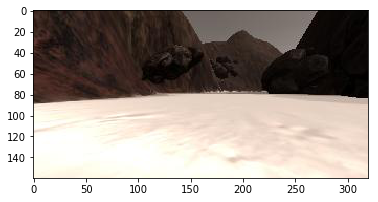

In [3]:
path = '../test_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

## Calibration Data
Read in and display example grid and rock sample calibration images.  You'll use the grid for perspective transform and the rock image for creating a new color selection that identifies these samples of interest. 

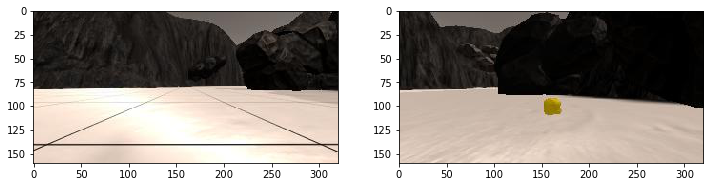

In [4]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = '../calibration_images/example_grid1.jpg'
example_rock = '../calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

## Perspective Transform

Define the perspective transform function from the lesson and test it on an image.

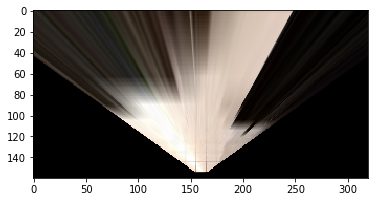

In [5]:
# Define a function to perform a perspective transform
# I've used the example grid image above to choose source points for the
# grid cell in front of the rover (each grid cell is 1 square meter in the sim)
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    
    return warped


# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
# this is just a rough guess, feel free to change it!
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped = perspect_transform(grid_img, source, destination)
plt.imshow(warped)
#scipy.misc.imsave('../output/warped_example.jpg', warped)

## Color Thresholding
Define the color thresholding function from the lesson and apply it to the warped image

**Implementation Detail**

* Instead of color_thresh() taught in tutorial, I used HSV format because it is more stable to intensity and color variation.

* I also store the threshold values and tranformation matrix in the folder "params".
    1. params/trans_config.txt
       Stores the "source" and "destination" matrix for perspective transformation.

    2. params/path_thresh.txt
       Stores preset HSV threshold value for path detection.

    3. params/rock_thresh.txt
       Stores preset HSV threshold value for rock detection.
   
* On top of HSV color thresholding, detect_rock() also applies morphological processing to reduce noise.

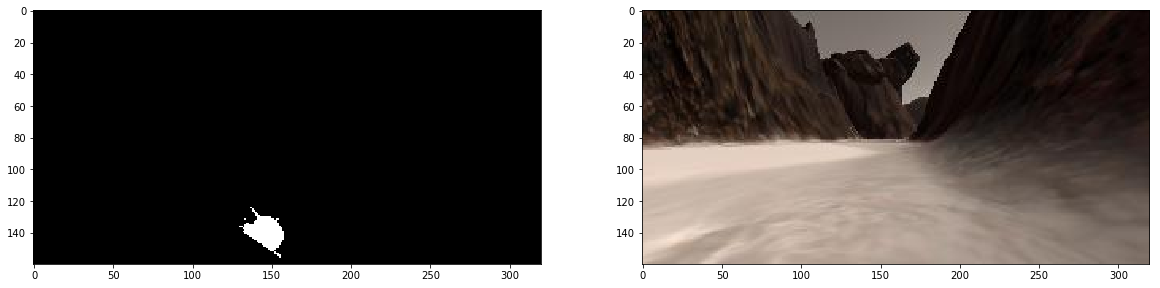

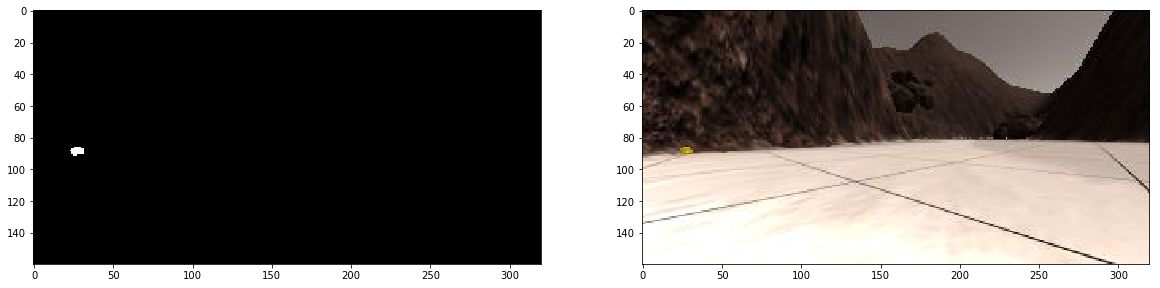

In [6]:
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all thre threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

# load preset parameters for perspective transform
def load_trans_config(filename = 'params/trans_config.txt'):
    with open(filename,'r') as f:
        lines = f.readlines()
    temp = []
    for i in range(4):
        y, x = lines[i].rstrip('\n').split(', ')
        temp.append([y, x])
    source = np.float32(temp)

    del temp[:]
    for i in range(4,8):
        y, x = lines[i].rstrip('\n').split(', ')
        temp.append([y, x])
    destination = np.float32(temp)
    return source, destination

# load preset parameters for image thresholding
def load_thresh(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    lower = np.array(lines[0].rstrip('\n').split(', '), np.uint8)
    upper = np.array(lines[1].rstrip('\n').split(', '), np.uint8)

    return lower, upper

# compute centroid and area of a binary image
def bw_info(mask):
    x, y = np.nonzero(mask)
    if len(x) == 0:
        return -1,-1,0
    xc = np.mean(x, dtype = int)
    yc = np.mean(y, dtype = int)
    area = len(x)   # area is proportional to confidence
    return xc, yc, area

# threshold rock pixels
def detect_rock(img):
    rock_lower, rock_upper = load_thresh('params/rock_thresh.txt')
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, rock_lower, rock_upper)
    
    # morphological processing
    kernel = np.ones((3,3),np.int8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask

# threshold navigable images
def detect_path(img):
    path_lower, path_upper = load_thresh('params/path_thresh.txt')
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    navigable = cv2.inRange(hsv, path_lower, path_upper)
    return navigable

# demo
rock_img = cv2.imread('../calibration_images/rock_samples/rock.jpg')
path_img = cv2.imread('../calibration_images/path_samples/robocam_2017_07_05_19_00_15_886.jpg')
source, destination = load_trans_config()

path_warped = perspect_transform(path_img,source, destination)
path_threshed = detect_path(path_warped)

fig, axes = plt.subplots(1,2,figsize=(20, 10))
axes[0].imshow(path_threshed, cmap='gray')
axes[1].imshow(cv2.cvtColor(path_img, cv2.COLOR_BGR2RGB))
plt.show()

rock_thresh = detect_rock(rock_img)
fig, axes = plt.subplots(1,2,figsize=(20, 10))
axes[0].imshow(rock_thresh, cmap='gray')
axes[1].imshow(cv2.cvtColor(rock_img, cv2.COLOR_BGR2RGB))
plt.show()
#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

## Coordinate Transformations
Define the functions used to do coordinate transforms and apply them to an image.

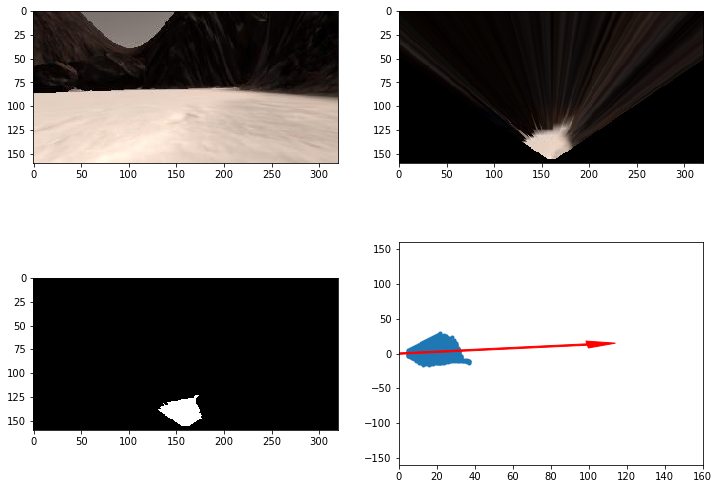

In [7]:
# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped = perspect_transform(image, source, destination)
threshed = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)



## Read in saved data and ground truth map of the world

Class Databucket is meant for storing telemetry data and pathnames to images. When you instantiate this class (`data = Databucket()`) you'll have a global variable called `data` that you can refer to for telemetry and map data within the `process_image()` function in the following cell.

In order to track the position of rock, I wrote the class `Rock`. It will 
compare proximity of a new sample from robot vision and tell if the rock in the
vision belongs to this instance. The proximity score is based on manhattan 
distance for simplicity. An Rock instance stores 5 measurements. Each 
measurement is weighted by their area, because the condidence of each 
measurement is assumed to be proportional to their area. The position() method
calculates the weighted position among the five measurements.

In [8]:
# Import pandas and read in csv file as a dataframe
import pandas as pd
# Change the path below to your data directory
# If you are in a locale (e.g., Europe) that uses ',' as the decimal separator
# change the '.' to ','
df = pd.read_csv('../test_dataset/robot_log.csv', delimiter=';', decimal='.')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = 0 # This will be a running index
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap
        self.rocks = [] # stores the position of rocks

class Rock():
    def __init__(self, (x, y), area):
        self.pos = [(x,y)]
        self.area = [area]  # confidence is proportional to area

    def __str__(self):
        x, y = self.position()
        return 'Rock at ({}, {}) with size {}'.format(x, y, np.mean(self.area))

    def sort(self):
        new_pos = []
        new_area = []
        # sort by area
        for a, p in sorted(zip(self.area, self.pos)):
            new_pos.append(p)
            new_area.append(a)
        self.area = new_area
        self.pos = new_pos

    def position(self):
        # weighted average of position
        A = sum(self.area)
        xp = 0.
        yp = 0.
        for i in xrange(len(self.area)):
            xp += self.pos[i][0] * self.area[i] / A
            yp += self.pos[i][1] * self.area[i] / A
        return int(xp), int(yp)

    def proximity_score(self, (x, y)):
        # proximity is evaluated by manhattan distance for simplicity
        xp, yp = self.position()
        return abs(xp-x) + abs(yp-y)

    def label(self, (x, y), area):
        # add a new observation
        self.pos.append((x, y))
        self.area.append(area)
        self.sort()
        # only keep five rocks with largest area
        if len(self.pos) > 5:
            self.pos.pop(0)
            self.area.pop(0)

## Write a function to process stored images

In process_image(), the image processing functions are utilized. I arranged the robot vision images (or the thresheld warped image) in the bottom right section. In the robot vision, blue is navigable, red is obstacle and yellow is rock sample.

The world map was constructed based on the world pixels of robot vision images.
Because the navigable region is usually less than the obstacle, I increase the
navigable by 15 each iteration. Also to eliminate ambibuity, I decrease other
color channel by the same amount.

Finally, the Databucket has a list of Rocks. The weighted position of each rock
will be plotted on the worldmap as white circles.

In [9]:

# Define a function to pass stored images to
# reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
def process_image(img):
    global source, destination, data
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
        
    # UPPER LEFT CORNER: original image
    output_image[0:img.shape[0], 0:img.shape[1]] = img

    # UPPDER RIGHT CORNER: warped image
    warped = perspect_transform(img, source, destination)
    output_image[0:img.shape[0], img.shape[1]:] = warped

    # BOTTOM RIGHT CORNER: navigable and obstacle threshold
    bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    rock = detect_rock(bgr)
    navigable = detect_path(bgr)
    obstacle = cv2.bitwise_not(navigable)

    navigable_warped = perspect_transform(navigable, source, destination)
    obstacle_warped = perspect_transform(obstacle, source, destination)
    rock_warped = perspect_transform(rock, source, destination)

    filtered = np.zeros((rock_warped.shape[0], rock_warped.shape[1],3),np.uint8)
    xpix, ypix = np.nonzero(obstacle_warped)
    filtered[xpix, ypix, :] = [255,0,0]
    xpix, ypix = np.nonzero(navigable_warped)
    filtered[xpix, ypix, :] = [0,0,255]
    xpix, ypix = np.nonzero(rock_warped)
    filtered[xpix, ypix, :] = [255,255,0]
    output_image[img.shape[0]:img.shape[0]+navigable_warped.shape[0], img.shape[1]:,:] = filtered

    # Construct navigable map
    nav_xpix, nav_ypix = rover_coords(navigable_warped)
    if len(nav_xpix) > 0:
        nav_x_world, nav_y_world = pix_to_world(nav_xpix, nav_ypix, data.xpos[data.count], 
                data.ypos[data.count], data.yaw[data.count], 200, scale=20)
        data.worldmap[nav_y_world, nav_x_world, 2] = np.clip(data.worldmap[nav_y_world, nav_x_world,2]+15, 0, 255)
        data.worldmap[nav_y_world, nav_x_world, 0] = np.clip(data.worldmap[nav_y_world, nav_x_world,0]-15, 0, 255)
        data.ground_truth[nav_y_world, nav_x_world, 1] = np.clip(data.ground_truth[nav_y_world, nav_x_world, 1]-5,0,180)
    
    obs_xpix, obs_ypix = rover_coords(obstacle_warped)
    if len(obs_xpix) > 0:
        obs_x_world, obs_y_world = pix_to_world(obs_xpix, obs_ypix, data.xpos[data.count], 
                data.ypos[data.count], data.yaw[data.count], 200, scale=20)
        data.worldmap[obs_y_world, obs_x_world, 2] = np.clip(data.worldmap[obs_y_world, obs_x_world,2]-3, 0, 255)
        data.worldmap[obs_y_world, obs_x_world, 0] = np.clip(data.worldmap[obs_y_world, obs_x_world,0]+3, 0, 255)
        data.ground_truth[obs_y_world, obs_x_world, 1] = np.clip(data.ground_truth[obs_y_world, obs_x_world, 1]-1,0,180)
    
    rock_xpix, rock_ypix = rover_coords(rock_warped)
    if len(rock_xpix) > 5:
        rock_x_world, rock_y_world = pix_to_world(rock_xpix, rock_ypix, data.xpos[data.count], 
                data.ypos[data.count], data.yaw[data.count], 200, scale=20)
        rock_x_center = np.mean(rock_x_world)
        rock_y_center = np.mean(rock_y_world)
        rock_area = len(rock_x_world)
        matched = False
        for r in data.rocks:
            if r.proximity_score((rock_x_center, rock_y_center)) < 15:
                r.label((rock_x_center, rock_y_center), rock_area)
                matched = True
        if not matched:
            data.rocks.append(Rock((rock_x_center, rock_y_center), rock_area))
        
    # BOTTOM LEFT CORNER: world map
    # NOTE: x_world & y_world are flipped
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
    for r in data.rocks:
        x, y = r.position()
        cv2.circle(img = map_add,center = (x, y), radius = 2, color = [255,255,255], thickness = -1)
    output_image[img.shape[0]:, 0:data.worldmap.shape[1], :] = np.flipud(map_add)
        # Then putting some text over the image
    cv2.putText(output_image,"Vision-Based Mapping and Navigation", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    if data.count < len(data.images) - 1:
        data.count += 1 # Keep track of the index in the Databucket()
    
    return output_image

## Make a video from processed image data
Use the [moviepy](https://zulko.github.io/moviepy/) library to process images and create a video.
  

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


# Define pathname to save the output video
output = '../output/test_mapping.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
clip = ImageSequenceClip(data.images, fps=60) # Note: output video will be sped up because 
                                          # recording rate in simulator is fps=25
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ../output/test_mapping.mp4
[MoviePy] Writing video ../output/test_mapping.mp4


100%|██████████| 283/283 [00:09<00:00, 31.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output/test_mapping.mp4 

CPU times: user 18.6 s, sys: 156 ms, total: 18.8 s
Wall time: 9.26 s


### This next cell should function as an inline video player
If this fails to render the video, try running the following cell (alternative video rendering method).  You can also simply have a look at the saved mp4 in your `/output` folder

In [11]:

from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

### Below is an alternative way to create a video in case the above cell did not work.

In [12]:
import io
import base64
video = io.open(output, 'r+b').read()
encoded_video = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded_video.decode('ascii')))